In [1]:
import os 
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


### Basic Imports

In [2]:
MAIN_DIR = '/content/drive/My Drive/Colab Notebooks/openpose/DLF2020/dlf2020/src/AmyExperiments/papertransformer'
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/openpose/DLF2020/dlf2020/src/AmyExperiments/backtranslation/data'
MODEL_DIR = os.path.join(MAIN_DIR, 'model')
CONF_DIR = os.path.join(MAIN_DIR, 'conf')

UNK_TOKEN = '<unk>'
PAD_TOKEN = '<pad>'
EOS_TOKEN = '</s>'
BOS_TOKEN = '<s>'

TARGET_PAD = 0.0

DEFAULT_UNK_ID = lambda: 0

!cp /content/drive/My\ Drive/Colab\ Notebooks/openpose/DLF2020/dlf2020/src/AmyExperiments/papertransformer/vocabulary.py .
!cp /content/drive/My\ Drive/Colab\ Notebooks/openpose/DLF2020/dlf2020/src/AmyExperiments/papertransformer/initialization.py .
!cp /content/drive/My\ Drive/Colab\ Notebooks/openpose/DLF2020/dlf2020/src/AmyExperiments/papertransformer/transformer_layers.py .
!cp /content/drive/My\ Drive/Colab\ Notebooks/openpose/DLF2020/dlf2020/src/AmyExperiments/papertransformer/batch.py .
!cp /content/drive/My\ Drive/Colab\ Notebooks/openpose/DLF2020/dlf2020/src/AmyExperiments/papertransformer/loss.py .
!cp /content/drive/My\ Drive/Colab\ Notebooks/openpose/DLF2020/dlf2020/src/AmyExperiments/papertransformer/builders.py .
!cp /content/drive/My\ Drive/Colab\ Notebooks/openpose/DLF2020/dlf2020/src/AmyExperiments/papertransformer/dtw.py .
!cp /content/drive/My\ Drive/Colab\ Notebooks/openpose/DLF2020/dlf2020/src/AmyExperiments/papertransformer/plot_videos.py .


import yaml
import numpy as np
import random
import pickle
import sys
from typing import Optional
import queue
import glob
import time
from logging import Logger
import logging

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torchtext.data import Dataset, Example, Field, BucketIterator, Iterator

from collections import defaultdict, Counter
from vocabulary import build_vocab
from initialization import initialize_model
from transformer_layers import TransformerEncoderLayer, PositionalEncoding, TransformerDecoderLayer
from vocabulary import Vocabulary
from batch import Batch
from loss import RegLoss
from builders import build_optimizer, build_scheduler, build_gradient_clipper
from dtw import dtw
from plot_videos import plot_video, alter_DTW_timing

### Helper functions

In [3]:
def load_config(path="model.yaml") -> dict:
    """
    Loads and parses a YAML configuration file.

    :param path: path to YAML configuration file
    :return: configuration dictionary
    """
    with open(os.path.join(CONF_DIR, path), 'r') as ymlfile:
        cfg = yaml.safe_load(ymlfile)
    return cfg

def set_seed(seed: int) -> None:
    """
    Set the random seed for modules torch, numpy and random.

    :param seed: random seed
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def freeze_params(module: nn.Module) -> None:
    """
    Freeze the parameters of this module,
    i.e. do not update them during training

    :param module: freeze parameters of this module
    """
    for _, p in module.named_parameters():
        p.requires_grad = False

def subsequent_mask(size: int) -> Tensor:
    """
    Mask out subsequent positions (to prevent attending to future positions)
    Transformer helper function.

    :param size: size of mask (2nd and 3rd dim)
    :return: Tensor with 0s and 1s of shape (1, size, size)
    """
    mask = np.triu(np.ones((1, size, size)), k=1).astype('uint8')

    return torch.from_numpy(mask) == 0 # Turns it into True and False's

def symlink_update(target, link_name):
    try:
        os.symlink(target, link_name)
    except FileExistsError as e:
        if e.errno == errno.EEXIST:
            os.remove(link_name)
            os.symlink(target, link_name)
        else:
            raise e

def load_checkpoint(path: str, use_cuda: bool = True) -> dict:
    """
    Load model from saved checkpoint.

    :param path: path to checkpoint
    :param use_cuda: using cuda or not
    :return: checkpoint (dict)
    """
    assert os.path.isfile(path), "Checkpoint %s not found" % path
    checkpoint = torch.load(path, map_location='cuda' if use_cuda else 'cpu')
    return checkpoint

class ConfigurationError(Exception):
    """ Custom exception for misspecifications of configuration """


def get_latest_checkpoint(ckpt_dir, post_fix="every", model_type='_tf') -> Optional[str]:
    """
    Returns the latest checkpoint (by time) from the given directory, of either every validation step or best
    If there is no checkpoint in this directory, returns None

    :param ckpt_dir: directory of checkpoint
    :param post_fixe: type of checkpoint, either "_every" or "_best"

    :return: latest checkpoint file
    """
    # Find all the every validation checkpoints
    list_of_files = glob.glob("{}/*{}{}.ckpt".format(ckpt_dir, post_fix, model_type))
    latest_checkpoint = None
    if list_of_files:
        latest_checkpoint = max(list_of_files, key=os.path.getctime)
    return latest_checkpoint

def log_cfg(cfg: dict, logger: Logger, prefix: str = "cfg"):
    """
    Write configuration to log.

    :param cfg: configuration to log
    :param logger: logger that defines where log is written to
    :param prefix: prefix for logging
    """
    for k, v in cfg.items():
        if isinstance(v, dict):
            p = ".".join([prefix, k])
            log_cfg(v, logger, prefix=p)
        else:
            p = ".".join([prefix, k])
            logger.info("{:34s} : {}".format(p, v))

def make_logger(model_dir: str, log_file: str = "inference.log") -> Logger:
    """
    Create a logger for logging the training process.

    :param model_dir: path to logging directory
    :param log_file: path to logging file
    :return: logger object
    """
    #if not logger.handlers:
    logger = logging.getLogger(__name__)
    while len(logger.handlers) > 0:
        h = logger.handlers[0]
        print('removing {}'.format(h))
        logger.removeHandler(h)
    logger.propagate = False
    logger.setLevel(logging.INFO)
    # Create handlers
    c_handler = logging.StreamHandler()
    f_handler = logging.FileHandler(os.path.join(model_dir, log_file), mode='w')

    # Create formatters and add it to handlers
    c_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    f_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    c_handler.setFormatter(c_format)
    f_handler.setFormatter(f_format)

    # Add handlers to the logger
    logger.addHandler(c_handler)
    logger.addHandler(f_handler)

    return logger

### Data Loading

In [15]:
def build_vocab(field: str, max_size: int, min_freq: int, dataset: Dataset,
                vocab_file: str = None) -> Vocabulary:
    """
    Builds vocabulary for a torchtext `field` from given`dataset` or
    `vocab_file`.

    :param field: attribute e.g. "src"
    :param max_size: maximum size of vocabulary
    :param min_freq: minimum frequency for an item to be included
    :param dataset: dataset to load data for field from
    :param vocab_file: file to store the vocabulary,
        if not None, load vocabulary from here
    :return: Vocabulary created from either `dataset` or `vocab_file`
    """

    if vocab_file is not None:
        # load it from file
        vocab = Vocabulary(file=vocab_file)
    else:
        # create newly
        def filter_min(counter: Counter, min_freq: int):
            """ Filter counter by min frequency """
            filtered_counter = Counter({t: c for t, c in counter.items()
                                        if c >= min_freq})
            return filtered_counter

        def sort_and_cut(counter: Counter, limit: int):
            """ Cut counter to most frequent,
            sorted numerically and alphabetically"""
            # sort by frequency, then alphabetically
            tokens_and_frequencies = sorted(counter.items(),
                                            key=lambda tup: tup[0])
            tokens_and_frequencies.sort(key=lambda tup: tup[1], reverse=True)
            vocab_tokens = [i[0] for i in tokens_and_frequencies[:limit]]
            return vocab_tokens

        tokens = []
        for i in dataset.examples:
            if field == "src":
                tokens.extend(i.src)
            elif field == "trg":
                tokens.extend(i.trg)
            elif field == 'emb':
                tokens.extend(i.emb)

        counter = Counter(tokens)
        if min_freq > -1:
            counter = filter_min(counter, min_freq)
        vocab_tokens = sort_and_cut(counter, max_size)
        assert len(vocab_tokens) <= max_size

        vocab = Vocabulary(tokens=vocab_tokens)
        assert len(vocab) <= max_size + len(vocab.specials)
        assert vocab.itos[DEFAULT_UNK_ID()] == UNK_TOKEN

    # check for all except for UNK token whether they are OOVs
    for s in vocab.specials[1:]:
        assert not vocab.is_unk(s)

    return vocab

def load_data(cfg: dict):
    
    # read parsed data
    # list of ['video_id', 'skeletons', 'frame_cnt', 'word', 'embedding']
    # skeleton shape [frame #, skeleton + counter = 151]

    train_path = os.path.join(DATA_DIR, 'test.cleaned.pkl')
    val_path = os.path.join(DATA_DIR, 'test.cleaned.pkl')
    level = "word"
    data_cfg = cfg["data"]
    src_lang = data_cfg["src"] #gloss
    trg_lang = data_cfg["trg"] #skels
    lowercase = False
    max_sent_length = data_cfg["max_sent_length"] # 1
    trg_size = cfg["model"]["trg_size"] + 1 # to account for counter
    skip_frames = data_cfg.get("skip_frames", 1)

    EOS_TOKEN = '</s>'
    tok_fun = lambda s: list(s) if level == "char" else s.split()
    
    src_field = Field(init_token=None,
                      pad_token=PAD_TOKEN, tokenize=tok_fun,
                      batch_first=True, lower=lowercase,
                      unk_token=UNK_TOKEN,
                      include_lengths=True)
        

    reg_trg_field = Field(sequential=True,
                          use_vocab=False,
                          dtype=torch.float32,
                          batch_first=True,
                          include_lengths=False,
                          pad_token=torch.ones((trg_size))*TARGET_PAD)
    
    embedding_field = Field(sequential=True,
                            use_vocab=False,
                            dtype=torch.float32,
                            batch_first=True,
                            include_lengths=True)


    train_data = SignProdDataset(fields=(embedding_field, reg_trg_field, src_field),
                                 path=train_path,
                                 trg_size=trg_size,
                                 skip_frames=skip_frames)
    
    src_vocab = build_vocab(field="emb", min_freq=1,
                            max_size=sys.maxsize,
                            dataset=train_data, vocab_file=None)
    
    src_field.vocab = src_vocab
    trg_vocab = [None]*(trg_size)

      # Create the Validation Data
    dev_data = SignProdDataset(fields=(embedding_field, reg_trg_field, src_field),
                               path=val_path,
                               trg_size=trg_size,
                               skip_frames=skip_frames)
    
    
    return train_data, dev_data, src_vocab, trg_vocab

global max_src_in_batch, max_tgt_in_batch


# pylint: disable=unused-argument,global-variable-undefined
def token_batch_size_fn(new, count, sofar):
    """Compute batch size based on number of tokens (+padding)."""
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch, len(new.src))
    src_elements = count * max_src_in_batch
    if hasattr(new, 'trg'):  # for monolingual data sets ("translate" mode)
        max_tgt_in_batch = max(max_tgt_in_batch, len(new.trg) + 2)
        tgt_elements = count * max_tgt_in_batch
    else:
        tgt_elements = 0
    return max(src_elements, tgt_elements)

class SignProdDataset(Dataset):
    def __init__(self, 
                 fields,
                 path,
                 trg_size,
                 skip_frames=1,
                 **kwargs):
        if not isinstance(fields[0], (tuple, list)):
            fields = [('src', fields[0]), ('trg', fields[1]), ('emb', fields[2])]
        
        examples = []
        with open(path, 'rb') as data_file:
            dataset = pickle.load(data_file)
        with open(os.path.join(DATA_DIR, 'embedding.200.pkl') ,'rb') as embed_file:
            embed_dict= pickle.load(embed_file)

        for i, skeleton in enumerate(dataset["skeleton"]):
            src_line = dataset["gloss"][i].replace(' ', '')
            # add start frame (zeros)
            start_frame = np.zeros((1, skeleton.shape[-1]))
            #start_frame[0, 0:200] = embed_dict[src_line].squeeze()
            with_start_frame = np.concatenate((start_frame, skeleton))
            normalized = with_start_frame + 1e-8

            if skip_frames > 1:
              normalized = normalized[0::skip_frames]

            # add counter here
            counters = np.arange(0,len(normalized),1)/len(normalized)
            with_counter = np.concatenate((normalized, counters[:, np.newaxis]), axis=1)

            # set embedding
            embed_x = dataset["embedding"][i][np.newaxis, :] #embed_dict[src_line][np.newaxis, :]

            examples.append(Example.fromlist([embed_x, with_counter, src_line], fields))
            super(SignProdDataset, self).__init__(examples, fields, **kwargs)
         
            
def make_data_iter(dataset: Dataset,
                   batch_size: int,
                   batch_type: str = "sentence",
                   train: bool = False,
                   shuffle: bool = False) -> Iterator:
    """
    Returns a torchtext iterator for a torchtext dataset.

    :param dataset: torchtext dataset containing src and optionally trg
    :param batch_size: size of the batches the iterator prepares
    :param batch_type: measure batch size by sentence count or by token count
    :param train: whether it's training time, when turned off,
        bucketing, sorting within batches and shuffling is disabled
    :param shuffle: whether to shuffle the data before each epoch
        (no effect if set to True for testing)
    :return: torchtext iterator
    """

    batch_size_fn = token_batch_size_fn if batch_type == "token" else None

    if train:
        # optionally shuffle and sort during training
        data_iter = BucketIterator(
            repeat=False, sort=False, dataset=dataset,
            batch_size=batch_size, batch_size_fn=batch_size_fn,
            train=True, sort_within_batch=True,
            sort_key=lambda x: len(x.src), shuffle=shuffle)
    else:
        # don't sort/shuffle for validation/inference
        data_iter = BucketIterator(
            repeat=False, dataset=dataset,
            batch_size=batch_size, batch_size_fn=batch_size_fn,
            train=False, sort=False)

    return data_iter

import torch
import torch.nn.functional as F


class Batch:
    """Object for holding a batch of data with mask during training.
    Input is a batch from a torch text iterator.
    """

    def __init__(self, torch_batch, pad_index, model):

        """
        Create a new joey batch from a torch batch.
        This batch extends torch text's batch attributes with src and trg
        length, masks, number of non-padded tokens in trg.
        Furthermore, it can be sorted by src length.

        :param torch_batch:
        :param pad_index:
        :param use_cuda:
        """
        self.src, self.src_lengths = torch_batch.src

        self.emb, _ = torch_batch.emb
        self.src_mask = (self.emb != pad_index).unsqueeze(1)
        self.nseqs = self.src.size(0)
        self.trg_input = None
        self.trg = None
        self.trg_mask = None
        self.trg_lengths = None
        self.ntokens = None

        self.padded_src = torch.zeros(self.nseqs, self.src.shape[1], 240)
        self.padded_src[:, :, 0:200] = self.src


        self.use_cuda = model.use_cuda
        self.target_pad = TARGET_PAD
        # Just Count
        self.just_count_in = model.just_count_in
        # Future Prediction
        self.future_prediction = model.future_prediction

        if hasattr(torch_batch, "trg"):
            trg = torch_batch.trg
            trg_lengths = torch_batch.trg.shape[1]
            # trg_input is used for teacher forcing, last one is cut off
            # Remove the last frame for target input, as inputs are only up to frame N-1
            self.trg_input = trg.clone()[:, :-1,:]

            self.trg_lengths = trg_lengths
            # trg is used for loss computation, shifted by one since BOS
            self.trg = trg.clone()[:, 1:, :]

            # Just Count
            if self.just_count_in:
                # If Just Count, cut off the first frame of trg_input
                self.trg_input = self.trg_input[:, :, -1:]

            # Future Prediction
            if self.future_prediction != 0:
                # Loop through the future prediction, concatenating the frames shifted across once each time
                future_trg = torch.Tensor()
                # Concatenate each frame (Not counter)
                for i in range(0, self.future_prediction):
                    future_trg = torch.cat((future_trg, self.trg[:, i:-(self.future_prediction - i), :-1].clone()), dim=2)
                # Create the final target using the collected future_trg and original trg
                self.trg = torch.cat((future_trg, self.trg[:,:-self.future_prediction,-1:]), dim=2)

                # Cut off the last N frames of the trg_input
                self.trg_input = self.trg_input[:, :-self.future_prediction, :]

            # Target Pad is dynamic, so we exclude the padded areas from the loss computation
            trg_mask = (self.trg_input != self.target_pad).unsqueeze(1)
            # This increases the shape of the target mask to be even (16,1,120,120) -
            # adding padding that replicates - so just continues the False's or True's
            pad_amount = self.trg_input.shape[1] - self.trg_input.shape[2]
            # Create the target mask the same size as target input
            self.trg_mask = (F.pad(input=trg_mask.double(), pad=(pad_amount, 0, 0, 0), mode='replicate') == 1.0)
            self.ntokens = (self.trg != pad_index).data.sum().item()

        if self.use_cuda:
            self._make_cuda()

    # If using Cuda
    def _make_cuda(self):
        """
        Move the batch to GPU

        :return:
        """
        self.src = self.src.cuda()
        self.src_mask = self.src_mask.cuda()

        if self.trg_input is not None:
            self.trg_input = self.trg_input.cuda()
            self.trg = self.trg.cuda()
            self.trg_mask = self.trg_mask.cuda()


### Initialization

In [7]:
from torch.nn.init import _calculate_fan_in_and_fan_out


def xavier_uniform_n_(w: Tensor, gain: float = 1., n: int = 4) -> None:
    """
    Xavier initializer for parameters that combine multiple matrices in one
    parameter for efficiency. This is e.g. used for GRU and LSTM parameters,
    where e.g. all gates are computed at the same time by 1 big matrix.

    :param w: parameter
    :param gain: default 1
    :param n: default 4
    """
    with torch.no_grad():
        fan_in, fan_out = _calculate_fan_in_and_fan_out(w)
        assert fan_out % n == 0, "fan_out should be divisible by n"
        fan_out //= n
        std = gain * math.sqrt(2.0 / (fan_in + fan_out))
        a = math.sqrt(3.0) * std
        nn.init.uniform_(w, -a, a)

# pylint: disable=too-many-branches
def intialize_discriminator(model: nn.Module, cfg: dict) -> None:
  
    # defaults: xavier, embeddings: normal 0.01, biases: zeros, no orthogonal
    gain = float(cfg.get("init_gain", 1.0))  # for xavier
    init = cfg.get("initializer", "xavier")
    init_weight = float(cfg.get("init_weight", 0.01))

    embed_init = cfg.get("embed_initializer", "normal")
    embed_init_weight = float(cfg.get("embed_init_weight", 0.01))
    embed_gain = float(cfg.get("embed_init_gain", 1.0))  # for xavier

    bias_init = cfg.get("bias_initializer", "zeros")
    bias_init_weight = float(cfg.get("bias_init_weight", 0.01))

    # pylint: disable=unnecessary-lambda, no-else-return
    def _parse_init(s, scale, _gain):
        scale = float(scale)
        assert scale > 0., "incorrect init_weight"
        if s.lower() == "xavier":
            return lambda p: nn.init.xavier_uniform_(p, gain=_gain)
        elif s.lower() == "uniform":
            return lambda p: nn.init.uniform_(p, a=-scale, b=scale)
        elif s.lower() == "normal":
            return lambda p: nn.init.normal_(p, mean=0., std=scale)
        elif s.lower() == "zeros":
            return lambda p: nn.init.zeros_(p)
        else:
            raise ValueError("unknown initializer")

    init_fn_ = _parse_init(init, init_weight, gain)
    bias_init_fn_ = _parse_init(bias_init, bias_init_weight, gain)
    with torch.no_grad():
        for name, p in model.named_parameters():
          if "bias" in name:
            bias_init_fn_(p)
          else:
            init_fn_(p)


### Building blocks of the Model

In [8]:
class Embeddings(nn.Module):

    """
    Updated Embedding Class
    """

    # pylint: disable=unused-argument
    def __init__(self,
                 embedding_dim: int = 64,
                 scale: bool = False,
                 vocab_size: int = 0,
                 padding_idx: int = 1,
                 freeze: bool = False,
                 **kwargs):
        """
        Create new embeddings for the vocabulary.
        Use scaling for the Transformer.

        :param embedding_dim:
        :param scale:
        :param vocab_size:
        :param padding_idx:
        :param freeze: freeze the embeddings during training
        """
        super(Embeddings, self).__init__()
        self.embedding_dim = embedding_dim
        self.scale = scale
        self.vocab_size = vocab_size
        #self.lut = nn.Embedding(vocab_size, self.embedding_dim,
        #                        padding_idx=padding_idx)
        self.lut = nn.Linear(200, embedding_dim)

        if freeze:
            freeze_params(self)

    # pylint: disable=arguments-differ
    def forward(self, x: Tensor) -> Tensor:
        """
        Perform lookup for input `x` in the embedding table.

        :param x: index in the vocabulary
        :return: embedded representation for `x`
        """
        if self.scale:
            return self.lut(x) * math.sqrt(self.embedding_dim)
        return self.lut(x)

    def __repr__(self):
        return "%s(embedding_dim=%d, vocab_size=%d)" % (
            self.__class__.__name__, self.embedding_dim, self.vocab_size)

        
class Decoder(nn.Module):
    """
    Base decoder class
    """

    @property
    def output_size(self):
        """
        Return the output size (size of the target vocabulary)

        :return:
        """
        return self._output_size

class TransformerDecoder(Decoder):
    """
    A transformer decoder with N masked layers.
    Decoder layers are masked so that an attention head cannot see the future.
    """

    def __init__(self,
                 num_layers: int = 4,
                 num_heads: int = 8,
                 hidden_size: int = 512,
                 ff_size: int = 2048,
                 dropout: float = 0.1,
                 emb_dropout: float = 0.1,
                 vocab_size: int = 1,
                 freeze: bool = False,
                 trg_size: int = 97,
                 decoder_trg_trg_: bool = True,
                 **kwargs):
        """
        Initialize a Transformer decoder.

        :param num_layers: number of Transformer layers
        :param num_heads: number of heads for each layer
        :param hidden_size: hidden size
        :param ff_size: position-wise feed-forward size
        :param dropout: dropout probability (1-keep)
        :param emb_dropout: dropout probability for embeddings
        :param vocab_size: size of the output vocabulary
        :param freeze: set to True keep all decoder parameters fixed
        :param kwargs:
        """
        super(TransformerDecoder, self).__init__()

        self._hidden_size = hidden_size

        # Dynamic output size depending on the target size
        self._output_size = trg_size

        # create num_layers decoder layers and put them in a list
        self.layers = nn.ModuleList([TransformerDecoderLayer(
                size=hidden_size, ff_size=ff_size, num_heads=num_heads,
                dropout=dropout, decoder_trg_trg=decoder_trg_trg_) for _ in range(num_layers)])

        self.pe = PositionalEncoding(hidden_size,mask_count=True)
        self.layer_norm = nn.LayerNorm(hidden_size, eps=1e-6)

        self.emb_dropout = nn.Dropout(p=emb_dropout)

        # Output layer to be the size of joints vector + 1 for counter (total is trg_size)
        self.output_layer = nn.Linear(hidden_size, trg_size, bias=False)

        if freeze:
            freeze_params(self)

    def forward(self,
                trg_embed: Tensor = None,
                encoder_output: Tensor = None,
                src_mask: Tensor = None,
                trg_mask: Tensor = None,
                **kwargs):
        """
        Transformer decoder forward pass.

        :param trg_embed: embedded targets
        :param encoder_output: source representations
        :param encoder_hidden: unused
        :param src_mask:
        :param unroll_steps: unused
        :param hidden: unused
        :param trg_mask: to mask out target paddings
                         Note that a subsequent mask is applied here.
        :param kwargs:
        :return:
        """
        assert trg_mask is not None, "trg_mask required for Transformer"

        # add position encoding to word embedding
        x = self.pe(trg_embed)
        # Dropout if given
        x = self.emb_dropout(x)

        padding_mask = trg_mask
        # Create subsequent mask for decoding
        sub_mask = subsequent_mask(
            trg_embed.size(1)).type_as(trg_mask)

        # Apply each layer to the input
        for layer in self.layers:
            x = layer(x=x, memory=encoder_output,
                      src_mask=src_mask, trg_mask=sub_mask, padding_mask=padding_mask)

        # Apply a layer normalisation
        x = self.layer_norm(x)
        # Output layer turns it back into vectors of size trg_size
        output = self.output_layer(x)

        return output, x, None, None

    def __repr__(self):
        return "%s(num_layers=%r, num_heads=%r)" % (
            self.__class__.__name__, len(self.layers),
            self.layers[0].trg_trg_att.num_heads)

class Encoder(nn.Module):
    """
    Base encoder class
    """
    @property
    def output_size(self):
        """
        Return the output size

        :return:
        """
        return self._output_size

class TransformerEncoder(Encoder):
    """
    Transformer Encoder
    """

    #pylint: disable=unused-argument
    def __init__(self,
                 hidden_size: int = 512,
                 ff_size: int = 2048,
                 num_layers: int = 8,
                 num_heads: int = 4,
                 dropout: float = 0.1,
                 emb_dropout: float = 0.1,
                 freeze: bool = False,
                 **kwargs):
        """
        Initializes the Transformer.
        :param hidden_size: hidden size and size of embeddings
        :param ff_size: position-wise feed-forward layer size.
          (Typically this is 2*hidden_size.)
        :param num_layers: number of layers
        :param num_heads: number of heads for multi-headed attention
        :param dropout: dropout probability for Transformer layers
        :param emb_dropout: Is applied to the input (word embeddings).
        :param freeze: freeze the parameters of the encoder during training
        :param kwargs:
        """
        super(TransformerEncoder, self).__init__()

        # build all (num_layers) layers
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(size=hidden_size, ff_size=ff_size,
                                    num_heads=num_heads, dropout=dropout)
            for _ in range(num_layers)])

        self.layer_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.pe = PositionalEncoding(hidden_size)
        self.emb_dropout = nn.Dropout(p=emb_dropout)
        self._output_size = hidden_size

        if freeze:
            freeze_params(self)

    #pylint: disable=arguments-differ
    def forward(self,
                embed_src: Tensor,
                src_length: Tensor,
                mask: Tensor) -> (Tensor, Tensor):
        """
        Pass the input (and mask) through each layer in turn.
        Applies a Transformer encoder to sequence of embeddings x.
        The input mini-batch x needs to be sorted by src length.
        x and mask should have the same dimensions [batch, time, dim].

        :param embed_src: embedded src inputs,
            shape (batch_size, src_len, embed_size)
        :param src_length: length of src inputs
            (counting tokens before padding), shape (batch_size)
        :param mask: indicates padding areas (zeros where padding), shape
            (batch_size, src_len, embed_size)
        :return:
            - output: hidden states with
                shape (batch_size, max_length, directions*hidden),
            - hidden_concat: last hidden state with
                shape (batch_size, directions*hidden)
        """

        x = embed_src
        # Add position encoding to word embeddings
        x = self.pe(x)
        # Add Dropout
        x = self.emb_dropout(x)

        # Apply each layer to the input
        for layer in self.layers:
            x = layer(x, mask)

        return self.layer_norm(x), None

    def __repr__(self):
        return "%s(num_layers=%r, num_heads=%r)" % (
            self.__class__.__name__, len(self.layers),
            self.layers[0].src_src_att.num_heads)


class RegLoss(nn.Module):
    """
    Regression Loss
    """

    def __init__(self, cfg, target_pad=0.0):
        super(RegLoss, self).__init__()

        self.loss = cfg["training"]["loss"].lower()

        if self.loss == "l1":
            self.criterion = nn.L1Loss()
        elif self.loss == "mse":
            self.criterion = nn.MSELoss()

        else:
            print("Loss not found - revert to default L1 loss")
            self.criterion = nn.L1Loss()

        model_cfg = cfg["model"]

        self.target_pad = target_pad
        self.loss_scale = model_cfg.get("loss_scale", 1.0)

    # pylint: disable=arguments-differ
    def forward(self, preds, targets):

        loss_mask = (targets != self.target_pad)
       
        # Find the masked predictions and targets using loss mask
        preds_masked = preds * loss_mask
        targets_masked = targets * loss_mask

        # Calculate loss just over the masked predictions
        loss = self.criterion(preds_masked, targets_masked)

        # Multiply loss by the loss scale
        if self.loss_scale != 1.0:
            loss = loss * self.loss_scale

        return loss

class Discriminator(nn.Module):
    """
    Consists of 3 1D CONV with 64 features 
    in between a RELU
    and final linear layer to sigmoid.

    Wil concatennate the skeleton with word 
    """
    def __init__(self, max_frame=88, feature=64, filter=10, embedding_size=240):
        super(Discriminator, self).__init__()
        self.max_frame = max_frame
        self.discriminate = nn.Sequential(
            # plus 1 for the word 
            nn.Conv1d(embedding_size, feature, filter),      
            nn.LeakyReLU(),
            nn.Conv1d(feature, feature, filter),
            nn.LeakyReLU(),
            nn.Conv1d(feature, 1, filter),
            nn.LeakyReLU(),
            nn.Linear(62, 1),
            nn.Sigmoid()
        )
        self.word_emb = nn.Linear(200, 240)


    def forward(self, input, word):
        # print(input.shape, word.shape)
        # padded input
        padded_input = torch.zeros(input.size(0), self.max_frame, 240).cuda()
        padded_input[:, 0:input.size(1), :] = input
        input = torch.cat((padded_input, self.word_emb(word)), 1).cuda()
        x = self.discriminate(input.permute(0, 2, 1))
        return x.squeeze()


### Main Model

In [9]:
class Model(nn.Module):
    """
    Base Model class
    """

    def __init__(self,
                 encoder: Encoder,
                 decoder: Decoder,
                 src_embed: Embeddings,
                 trg_embed: Embeddings,
                 src_vocab: Vocabulary,
                 trg_vocab: Vocabulary,
                 cfg: dict,
                 in_trg_size: int,
                 out_trg_size: int,
                 ) -> None:
        """
        Create a new encoder-decoder model

        :param encoder: encoder
        :param decoder: decoder
        :param src_embed: source embedding
        :param trg_embed: target embedding
        :param src_vocab: source vocabulary
        :param trg_vocab: target vocabulary
        """
        super(Model, self).__init__()

        model_cfg = cfg["model"]

        self.src_embed = src_embed
        self.trg_embed = trg_embed

        self.encoder = encoder
        self.decoder = decoder
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.bos_index = self.src_vocab.stoi[BOS_TOKEN]
        self.pad_index = self.src_vocab.stoi[PAD_TOKEN]
        self.eos_index = self.src_vocab.stoi[EOS_TOKEN]
        self.target_pad = TARGET_PAD

        self.use_cuda = cfg["training"]["use_cuda"]

        self.in_trg_size = in_trg_size
        self.out_trg_size = out_trg_size
        self.count_in = model_cfg.get("count_in",True)
        # Just Counter
        self.just_count_in = model_cfg.get("just_count_in",False)
        # Gaussian Noise
        self.gaussian_noise = model_cfg.get("gaussian_noise",False)
        # Gaussian Noise
        if self.gaussian_noise:
            self.noise_rate = model_cfg.get("noise_rate", 1.0)

        # Future Prediction - predict for this many frames in the future
        self.future_prediction = model_cfg.get("future_prediction", 0)

    # pylint: disable=arguments-differ
    def forward(self,
                src: Tensor,
                trg_input: Tensor,
                src_mask: Tensor,
                src_lengths: Tensor,
                trg_mask: Tensor = None) -> (
        Tensor, Tensor, Tensor, Tensor):
        """
        First encodes the source sentence.
        Then produces the target one word at a time.

        :param src: source input
        :param trg_input: target input
        :param src_mask: source mask
        :param src_lengths: length of source inputs
        :param trg_mask: target mask
        :return: decoder outputs
        """

        # Encode the source sequence
        encoder_output, encoder_hidden = self.encode(src=src,
                                                     src_length=src_lengths,
                                                     src_mask=src_mask)
        unroll_steps = trg_input.size(1)

        # Add gaussian noise to the target inputs, if in training
        if (self.gaussian_noise) and (self.training) and (self.out_stds is not None):

            # Create a normal distribution of random numbers between 0-1
            noise = trg_input.data.new(trg_input.size()).normal_(0, 1)
            # Zero out the noise over the counter
            noise[:,:,-1] = torch.zeros_like(noise[:, :, -1])

            # Need to add a zero on the end of
            if self.future_prediction != 0:
                self.out_stds = torch.cat((self.out_stds,torch.zeros_like(self.out_stds)))[:trg_input.shape[-1]]

            # Need to multiply by the standard deviations
            noise = noise * self.out_stds

            # Add to trg_input multiplied by the noise rate
            trg_input = trg_input + self.noise_rate*noise

        # Decode the target sequence
        skel_out, dec_hidden, _, _ = self.decode(encoder_output=encoder_output,
                                                 src_mask=src_mask, trg_input=trg_input,
                                                 trg_mask=trg_mask)

        gloss_out = None

        return skel_out, gloss_out

    def encode(self, src: Tensor, src_length: Tensor, src_mask: Tensor) \
        -> (Tensor, Tensor):
        """
        Encodes the source sentence.

        :param src:
        :param src_length:
        :param src_mask:
        :return: encoder outputs (output, hidden_concat)
        """
        # Encode an embedded source
        encode_output = self.encoder(self.src_embed(src), src_length, src_mask)

        return encode_output


    def decode(self, encoder_output: Tensor,
               src_mask: Tensor, trg_input: Tensor,
               trg_mask: Tensor = None) \
        -> (Tensor, Tensor, Tensor, Tensor):

        """
        Decode, given an encoded source sentence.

        :param encoder_output: encoder states for attention computation
        :param encoder_hidden: last encoder state for decoder initialization
        :param src_mask: source mask, 1 at valid tokens
        :param trg_input: target inputs
        :param unroll_steps: number of steps to unrol the decoder for
        :param decoder_hidden: decoder hidden state (optional)
        :param trg_mask: mask for target steps
        :return: decoder outputs (outputs, hidden, att_probs, att_vectors)
        """

        # Enbed the target using a linear layer
        trg_embed = self.trg_embed(trg_input)
        # Apply decoder to the embedded target
        decoder_output = self.decoder(trg_embed=trg_embed, encoder_output=encoder_output,
                               src_mask=src_mask,trg_mask=trg_mask)

        return decoder_output

    def calculate_generator_loss(self, skel_out, trg, loss_function: nn.Module):
        torso_loss = loss_function(skel_out[:, :, 0:16], trg[:, :, 0:16])
        hand_loss = loss_function(skel_out[:, :, 16:16+84], trg[:, :, 16:16+84])
        face_loss = loss_function(skel_out[:, :, 16+84:], trg[:, :, 16+84:])
        
        #batch_loss = loss_function(skel_out, batch.trg)
        batch_loss = torso_loss * 0.4 + hand_loss * 0.5 + face_loss * 0.1

        # If gaussian noise, find the noise for the next epoch
        if self.gaussian_noise:
            # Calculate the difference between prediction and GT, to find STDs of error
            with torch.no_grad():
                noise = skel_out.detach() - trg.detach()

            if self.future_prediction != 0:
                # Cut to only the first frame prediction + add the counter
                noise = noise[:, :, :noise.shape[2] // (self.future_prediction)]

        else:
            noise = None

        # return batch loss = sum over all elements in batch that are not pad
        return batch_loss, torso_loss.item(), hand_loss.item(), face_loss.item(), noise

    def get_loss_for_batch(self, batch: Batch, loss_function: nn.Module):
        """
        Compute non-normalized loss and number of tokens for a batch

        :param batch: batch to compute loss for
        :param loss_function: loss function, computes for input and target
            a scalar loss for the complete batch
        :return: batch_loss: sum of losses over non-pad elements in the batch
        """
        # Forward through the batch input
        skel_out, _ = self.forward(
            src=batch.src, trg_input=batch.trg_input,
            src_mask=batch.src_mask, src_lengths=batch.src_lengths,
            trg_mask=batch.trg_mask)

        # compute batch loss using skel_out and the batch target
        # do it by weight
        torso_loss = loss_function(skel_out[:, :, 0:16], batch.trg[:, :, 0:16])
        hand_loss = loss_function(skel_out[:, :, 16:16+84], batch.trg[:, :, 16:16+84])
        face_loss = loss_function(skel_out[:, :, 16+84:], batch.trg[:, :, 16+84:])
        
        #batch_loss = loss_function(skel_out, batch.trg)
        batch_loss = torso_loss * 0.4 + hand_loss * 0.5 + face_loss * 0.1

        # If gaussian noise, find the noise for the next epoch
        if self.gaussian_noise:
            # Calculate the difference between prediction and GT, to find STDs of error
            with torch.no_grad():
                noise = skel_out.detach() - batch.trg.detach()

            if self.future_prediction != 0:
                # Cut to only the first frame prediction + add the counter
                noise = noise[:, :, :noise.shape[2] // (self.future_prediction)]

        else:
            noise = None

        dtw = 0 #calculate_dtw(batch.trg, skel_out)
        # return batch loss = sum over all elements in batch that are not pad
        return batch_loss, torso_loss.item(), hand_loss.item(), face_loss.item(), noise

    def run_batch(self, batch: Batch, max_output_length: int,) -> (np.array, np.array):
        """
        Get outputs and attentions scores for a given batch

        :param batch: batch to generate hypotheses for
        :param max_output_length: maximum length of hypotheses
        :param beam_size: size of the beam for beam search, if 0 use greedy
        :param beam_alpha: alpha value for beam search
        :return: stacked_output: hypotheses for batch,
            stacked_attention_scores: attention scores for batch
        """
        # First encode the batch, as this can be done in all one go
        encoder_output, encoder_hidden = self.encode(
            batch.src, batch.src_lengths,
            batch.src_mask)

        # if maximum output length is not globally specified, adapt to src len
        if max_output_length is None:
            max_output_length = int(max(batch.src_lengths.cpu().numpy()) * 1.5)

        # Then decode the batch separately, as needs to be done iteratively
        # greedy decoding
        stacked_output, stacked_attention_scores = greedy(
                encoder_output=encoder_output,
                src_mask=batch.src_mask,
                embed=self.trg_embed,
                decoder=self.decoder,
                trg_input=batch.trg_input,
                model=self)

        return stacked_output, stacked_attention_scores

    def __repr__(self) -> str:
        """
        String representation: a description of encoder, decoder and embeddings

        :return: string representation
        """
        return "%s(\n" \
               "\tencoder=%s,\n" \
               "\tdecoder=%s,\n" \
               "\tsrc_embed=%s,\n" \
               "\ttrg_embed=%s)" % (self.__class__.__name__, self.encoder,
                   self.decoder, self.src_embed, self.trg_embed)
               
def build_model(cfg: dict = None,
                src_vocab = None,
                trg_vocab = None) -> Model:
    """
    Build and initialize the model according to the configuration.

    :param cfg: dictionary configuration containing model specifications
    :param src_vocab: source vocabulary
    :param trg_vocab: target vocabulary
    :return: built and initialized model
    """

    full_cfg = cfg
    cfg = cfg["model"]

    src_padding_idx = None
    trg_padding_idx = 0

    # Input target size is the joint vector length plus one for counter
    in_trg_size = cfg["trg_size"] + 1
    # Output target size is the joint vector length plus one for counter
    out_trg_size = cfg["trg_size"] + 1

    just_count_in = cfg.get("just_count_in", False)
    future_prediction = cfg.get("future_prediction", 0)

    #  Just count in limits the in target size to 1
    if just_count_in:
        in_trg_size = 1

    # Future Prediction increases the output target size
    if future_prediction != 0:
        # Times the trg_size (minus counter) by amount of predicted frames, and then add back counter
        out_trg_size = (out_trg_size - 1 ) * future_prediction + 1

    # Define source embedding

    with open(os.path.join(DATA_DIR, 'embedding.200.pkl') ,'rb') as f:
        embedding_dict = pickle.load(f)
    src_embed = Embeddings(
        embedding_dict=embedding_dict,
        **cfg["encoder"]["embeddings"], vocab_size=len(src_vocab),
        padding_idx=src_padding_idx)

    # Define target linear
    # Linear layer replaces an embedding layer - as this takes in the joints size as opposed to a token
    trg_linear = nn.Linear(in_trg_size, cfg["decoder"]["embeddings"]["embedding_dim"])

    ## Encoder -------
    enc_dropout = cfg["encoder"].get("dropout", 0.) # Dropout
    enc_emb_dropout = cfg["encoder"]["embeddings"].get("dropout", enc_dropout)
    assert cfg["encoder"]["embeddings"]["embedding_dim"] == \
           cfg["encoder"]["hidden_size"], \
           "for transformer, emb_size must be hidden_size"

    # Transformer Encoder
    encoder = TransformerEncoder(**cfg["encoder"],
                                 emb_size=src_embed.embedding_dim,
                                 emb_dropout=enc_emb_dropout)

    ## Decoder -------
    dec_dropout = cfg["decoder"].get("dropout", 0.) # Dropout
    dec_emb_dropout = cfg["decoder"]["embeddings"].get("dropout", dec_dropout)
    decoder_trg_trg = cfg["decoder"].get("decoder_trg_trg", True)
    # Transformer Decoder
    decoder = TransformerDecoder(
        **cfg["decoder"], encoder=encoder, vocab_size=len(trg_vocab),
        emb_size=trg_linear.out_features, emb_dropout=dec_emb_dropout,
        trg_size=out_trg_size, decoder_trg_trg_=decoder_trg_trg)

    # Define the model
    model = Model(encoder=encoder,
                  decoder=decoder,
                  src_embed=src_embed,
                  trg_embed=trg_linear,
                  src_vocab=src_vocab,
                  trg_vocab=trg_vocab,
                  cfg=full_cfg,
                  in_trg_size=in_trg_size,
                  out_trg_size=out_trg_size)

    # Custom initialization of model parameters
    initialize_model(model, cfg, src_padding_idx, trg_padding_idx)

    return model


### Main Train Call

In [10]:
class TrainManager:

    def __init__(self, model: Model, 
                 discriminator: Discriminator,
                 config: dict, test=False) -> None:

        train_config = config["training"]
        model_dir = os.path.join(MODEL_DIR, version)
        # If model continue, continues model from the latest checkpoint
        model_continue = train_config.get("continue", True)
        # If the directory has not been created, can't continue from anything
        if not os.path.isdir(model_dir):
            model_continue = False
        if test:
            model_continue = True

        # files for logging and storing
        self.model_dir = model_dir
        
        # Build validation files
        self.valid_report_file = "{}/validations.txt".format(self.model_dir)
        self.logger = make_logger(model_dir=self.model_dir)
        self.logging_freq = train_config.get('logging_freq', 100)

        # model
        self.model = model
        self.disc = discriminator
        self.pad_index = self.model.pad_index
        self.bos_index = self.model.bos_index
        self._log_parameters_list()
        self.target_pad = TARGET_PAD

        # New Regression loss - depending on config
        self.loss = RegLoss(cfg = config,
                            target_pad=self.target_pad)
        self.adv_loss = nn.BCELoss()

        self.normalization = "batch"

        # optimization
        self.learning_rate_min = train_config.get("learning_rate_min", 1.0e-8)
        self.clip_grad_fun = build_gradient_clipper(config=train_config)
        self.optimizer = build_optimizer(config=train_config, parameters=model.parameters())
        self.optimizerD = build_optimizer(config=train_config, parameters=discriminator.parameters())

        # validation & early stopping
        self.validation_freq = train_config.get("validation_freq", 1000)
        self.ckpt_best_queue = queue.Queue(maxsize=train_config.get("keep_last_ckpts", 1))
        self.ckpt_queue = queue.Queue(maxsize=1)

        self.val_on_train = config["data"].get("val_on_train", True)

        # TODO - Include Back Translation
        self.eval_metric = train_config.get("eval_metric", "dtw").lower()
        if self.eval_metric not in ['bleu', 'chrf', "dtw"]:
            raise ConfigurationError("Invalid setting for 'eval_metric', "
                                     "valid options: 'bleu', 'chrf', 'DTW'")
        self.early_stopping_metric = train_config.get("early_stopping_metric",
                                                       "eval_metric")

        # if we schedule after BLEU/chrf, we want to maximize it, else minimize
        # early_stopping_metric decides on how to find the early stopping point:
        # ckpts are written when there's a new high/low score for this metric
        if self.early_stopping_metric in ["loss","dtw"]:
            self.minimize_metric = True
        else:
            raise ConfigurationError("Invalid setting for 'early_stopping_metric', "
                                    "valid options: 'loss', 'dtw',.")

        # learning rate scheduling
        self.scheduler, self.scheduler_step_at = build_scheduler(
            config=train_config,
            scheduler_mode="min" if self.minimize_metric else "max",
            optimizer=self.optimizer,
            hidden_size=config["model"]["encoder"]["hidden_size"])

        # data & batch handling
        self.level = "word"
        self.shuffle = train_config.get("shuffle", True)
        self.epochs = train_config.get('epochs')
        self.batch_size = train_config["batch_size"]
        self.batch_type = "sentence"
        self.eval_batch_size = train_config.get("eval_batch_size",self.batch_size)
        self.eval_batch_type = train_config.get("eval_batch_type",self.batch_type)
        self.batch_multiplier = train_config.get("batch_multiplier", 1)

        # generation
        self.max_output_length = train_config.get("max_output_length", None)

        # CPU / GPU
        self.use_cuda = train_config["use_cuda"]
        if self.use_cuda:
            self.model.cuda()
            self.loss.cuda()
            self.disc.cuda()
            self.adv_loss.cuda()

        # initialize training statistics
        self.steps = 0
        # stop training if this flag is True by reaching learning rate minimum
        self.stop = False
        self.total_tokens = 0
        self.best_ckpt_iteration = 0
        # initial values for best scores
        self.best_ckpt_score = np.inf if self.minimize_metric else -np.inf
        # comparison function for scores
        self.is_best = lambda score: score < self.best_ckpt_score \
            if self.minimize_metric else score > self.best_ckpt_score

        ## Checkpoint restart
        # If continuing
        """
        if model_continue:
            # Get the latest checkpoint
            tf_ckpt = get_latest_checkpoint(model_dir, model_type='_tf')
            gan_ckpt = get_latest_checkpoint(model_dir, model_type='_gan')
            if tf_ckpt is None:
                self.logger.info(f"Can't find checkpoint in directory {tf_ckpt}")
            else:
                self.logger.info(f"Continuing model from {tf_ckpt} and {gan_ckpt}", )
                self.init_from_checkpoint(tf_ckpt, model_type='tf')
                self.init_from_checkpoint(gan_ckpt, model_type='gan')
        """
        # Skip frames
        self.skip_frames = config["data"].get("skip_frames", 1)

        ## -- Data augmentation --
        # Just Counter
        self.just_count_in = config["model"].get("just_count_in",False)
        # Gaussian Noise
        self.gaussian_noise = config["model"].get("gaussian_noise", False)
        
        if self.gaussian_noise:
            # How much the noise is added in
            self.noise_rate = config["model"].get("noise_rate", 1.0)

        if self.just_count_in and (self.gaussian_noise):
            raise ConfigurationError("Can't have both just_count_in and gaussian_noise as True")

        self.future_prediction = config["model"].get("future_prediction", 0)
        if self.future_prediction != 0:
            frames_predicted = [i for i in range(self.future_prediction)]
            print(f"Future prediction. Frames predicted: {frames_predicted}")

    # Save a checkpoint
    def _save_checkpoint(self, type="every", model_type="tf") -> None:
        # Define model path
        model_path = "{}/{}_{}_{}.ckpt".format(self.model_dir, self.steps, type, model_type)
        # Define State

        state = {
            "steps": self.steps,
            "total_tokens": self.total_tokens,
            "best_ckpt_score": self.best_ckpt_score,
            "best_ckpt_iteration": self.best_ckpt_iteration,
            "model_state": self.model.state_dict(),
            "optimizer_state": self.optimizer.state_dict(),
            "scheduler_state": self.scheduler.state_dict() if \
            self.scheduler is not None else None,
        }

        if model_type =="gan":
            state["model_state"] = self.disc.state_dict()
            state["optimizer_state"] = self.optimizerD.state_dict()

        torch.save(state, model_path)

        # If this is the best checkpoint
        if type == "best":
            if self.ckpt_best_queue.full():
              to_delete = self.ckpt_best_queue.get()  # delete oldest ckpt
              try:
                os.remove(to_delete)
              except FileNotFoundError:
                print(f"Wanted to delete old checkpoint {to_delete} but file does not exist.")
            self.ckpt_best_queue.put(model_path)

            best_path = "{}/best_{}.ckpt".format(self.model_dir, model_type)
            torch.save(state, best_path)

        # If this is just the checkpoint at every validation
        elif type == "every":
            if self.ckpt_queue.full():
              to_delete = self.ckpt_queue.get()  # delete oldest ckpt
              try:
                os.remove(to_delete)
              except FileNotFoundError:
                print(f"Wanted to delete old checkpoint {to_delete} but file does not exist.")

            self.ckpt_queue.put(model_path)
            every_path = "{}/every_{}.ckpt".format(self.model_dir, model_type)
            # overwrite every.ckpt
            torch.save(state, every_path)

    # Initialise from a checkpoint
    def init_from_checkpoint(self, path: str, model_type: str = "tf") -> None:
        # Find last checkpoint
        model_checkpoint = load_checkpoint(path=path, use_cuda=self.use_cuda)

        # restore model and optimizer parameters
        if model_type == "tf":
          self.model.load_state_dict(model_checkpoint["model_state"])
          self.optimizer.load_state_dict(model_checkpoint["optimizer_state"])

          if model_checkpoint["scheduler_state"] is not None and \
                  self.scheduler is not None:
              # Load the scheduler state
              self.scheduler.load_state_dict(model_checkpoint["scheduler_state"])

          # restore counts
          self.steps = model_checkpoint["steps"]
          self.total_tokens = model_checkpoint["total_tokens"]
          self.best_ckpt_score = model_checkpoint["best_ckpt_score"]
          self.best_ckpt_iteration = model_checkpoint["best_ckpt_iteration"]
        else:
          self.optimizerD.load_state_dict(model_checkpoint["optimizer_state"])
          self.disc.load_state_dict(model_checkpoint['model_state'])

        # move parameters to cuda
        if self.use_cuda:
            self.model.cuda()

    # Train and validate function
    def train_and_validate(self, train_data: Dataset, valid_data: Dataset) \
            -> None:
        # Make training iterator
        train_iter = make_data_iter(train_data,
                                    batch_size=self.batch_size,
                                    batch_type=self.batch_type,
                                    train=True, shuffle=self.shuffle)

        val_step = 0
        if self.gaussian_noise:
            all_epoch_noise = []
        # Loop through epochs
        epoch_start_time = time.time()
        for epoch_no in range(self.epochs):
            if self.scheduler is not None and self.scheduler_step_at == "epoch":
                self.scheduler.step(epoch=epoch_no)

            self.model.train()

            # Reset statistics for each epoch.
            start = time.time()
            total_valid_duration = 0
            start_tokens = self.total_tokens
            count = self.batch_multiplier - 1
            epoch_loss = 0
            epoch_torso_loss = 0
            epoch_hand_loss = 0
            epoch_face_loss = 0
            epoch_disc_real_loss= 0
            epoch_disc_fake_loss = 0
            epoch_total_generator_loss = 0
            epoch_generator_adv_loss = 0

            # If Gaussian Noise, extract STDs for each joint position
            if self.gaussian_noise:
                if len(all_epoch_noise) != 0:
                    self.model.out_stds = torch.mean(torch.stack(([noise.std(dim=[0]) for noise in all_epoch_noise])),dim=-2)
                else:
                    self.model.out_stds = None
                all_epoch_noise = []

            for batch in iter(train_iter):
                # reactivate training
                self.model.train()

                # create a Batch object from torchtext batch
                batch = Batch(torch_batch=batch,
                              pad_index=self.pad_index,
                              model=self.model)

                update = count == 0
                # Train the model on a batch

                batch_loss, torso_loss, hand_loss, face_loss, disc_real_loss, disc_fake_loss, total_generator_loss, generator_adv_loss, noise = self._train_batch(batch, update=update)
                # If Gaussian Noise, collect the noise
                if self.gaussian_noise:
                    # If future Prediction, cut down the noise size to just one frame
                    if self.future_prediction != 0:
                        all_epoch_noise.append(noise.reshape(-1, self.model.out_trg_size // self.future_prediction))
                    else:
                        all_epoch_noise.append(noise.reshape(-1,self.model.out_trg_size))

                count = self.batch_multiplier if update else count
                count -= 1
                epoch_loss += batch_loss.detach().cpu().numpy()
                epoch_torso_loss += torso_loss
                epoch_hand_loss += hand_loss
                epoch_face_loss += face_loss
                epoch_disc_real_loss += disc_real_loss
                epoch_disc_fake_loss += disc_fake_loss
                epoch_total_generator_loss += total_generator_loss
                epoch_generator_adv_loss += generator_adv_loss

                if self.scheduler is not None and self.scheduler_step_at == "step" and update:
                    self.scheduler.step()

                # log learning progress
                if self.steps % self.logging_freq == 0 and update:
                    elapsed = time.time() - start - total_valid_duration
                    elapsed_tokens = self.total_tokens - start_tokens
                    self.logger.info(
                        "Epoch %3d Step: %8d Batch Loss: %12.6f [Torso : %12.6f, Hand : %12.6f, Face : %12.6f]"
                        "Tokens per Sec: %8.0f, Lr: %.6f",
                        epoch_no + 1, self.steps, batch_loss, torso_loss, hand_loss, face_loss,
                        elapsed_tokens / elapsed,
                        self.optimizer.param_groups[0]["lr"])
                    start = time.time()
                    total_valid_duration = 0
                    start_tokens = self.total_tokens

                # validate on the entire dev set
                if self.steps % self.validation_freq == 0 and update:
                    self.logger.info("Starting validation calculation.")
                    valid_start_time = time.time()

                    valid_score, valid_loss, valid_references, valid_hypotheses, \
                        valid_inputs, all_dtw_scores, valid_file_paths = \
                        validate_on_data(
                            batch_size=self.eval_batch_size,
                            data=valid_data,
                            eval_metric=self.eval_metric,
                            model=self.model,
                            max_output_length=self.max_output_length,
                            loss_function=self.loss,
                            batch_type=self.eval_batch_type,
                            type="val",
                        )

                    val_step += 1

                    if self.early_stopping_metric == "loss":
                        ckpt_score = valid_loss
                    elif self.early_stopping_metric == "dtw":
                        ckpt_score = valid_score
                    else:
                        ckpt_score = valid_score

                    new_best = False
                    self.best = False
                    if self.is_best(ckpt_score):
                        self.best = True
                        self.best_ckpt_score = ckpt_score
                        self.best_ckpt_iteration = self.steps
                        self.logger.info(
                            'Hooray! New best validation result [%s]!',
                            self.early_stopping_metric)
                        if self.ckpt_queue.maxsize > 0:
                            self.logger.info("Saving new checkpoint.")
                            new_best = True
                            self._save_checkpoint(type="best", model_type='tf')
                            self._save_checkpoint(type="best", model_type="gan")

                        # Display these sequences, in this index order
                        display = list(range(0, len(valid_hypotheses), int(np.ceil(len(valid_hypotheses) / 13.15))))
                        self.produce_validation_video(
                            output_joints=valid_hypotheses,
                            inputs=valid_inputs,
                            references=valid_references,
                            model_dir=self.model_dir,
                            steps=self.steps,
                            display=display,
                            type="val_inf",
                            file_paths=valid_file_paths,
                        )

                    self._save_checkpoint(type="every", model_type='tf')
                    self._save_checkpoint(type="every", model_type="gan")


                    if self.scheduler is not None and self.scheduler_step_at == "validation":
                        self.scheduler.step(ckpt_score)

                    # append to validation report
                    self._add_report(
                        valid_score=valid_score, valid_loss=valid_loss,
                        eval_metric=self.eval_metric,
                        new_best=new_best, report_type="val",)

                    valid_duration = time.time() - valid_start_time
                    total_valid_duration += valid_duration
                    self.logger.info(
                        'Validation result at epoch %3d, step %8d: Val DTW Score: %6.2f, '
                        'loss: %8.4f,  duration: %.4fs',
                            epoch_no+1, self.steps, valid_score,
                            valid_loss, valid_duration)

                if self.stop:
                    break
            if self.stop:
                self.logger.info(
                    'Training ended since minimum lr %f was reached.',
                     self.learning_rate_min)
                break

            self.logger.info('Epoch %3d: total training loss %.5f [torso: %.5f, hand: %.5f, face: %.5f', epoch_no+1,
                             epoch_loss, epoch_torso_loss, epoch_hand_loss, epoch_face_loss)
            
            self.logger.info('Epoch %3d: disc loss [real: %.5f, fake: %.5f], generator [total: %.5f, adv: %.5f]', epoch_no+1,
                             epoch_disc_real_loss, epoch_disc_fake_loss, epoch_total_generator_loss, epoch_generator_adv_loss)
            
        else:
            self.logger.info('Training ended after %3d epochs.', epoch_no+1)
        self.logger.info('Best validation result at step %8d: %6.2f %s.',
                         self.best_ckpt_iteration, self.best_ckpt_score,
                         self.early_stopping_metric)


    # Train the batch
    def _train_batch(self, batch: Batch, update: bool = True):

        # normalize batch loss
        if self.normalization == "batch":
            normalizer = batch.nseqs
        elif self.normalization == "tokens":
            normalizer = batch.ntokens
        else:
            raise NotImplementedError("Only normalize by 'batch' or 'tokens'")

        # generated
        skel_out, _ = self.model.forward(
          src=batch.src, trg_input=batch.trg_input,
          src_mask=batch.src_mask, src_lengths=batch.src_lengths,
          trg_mask=batch.trg_mask)
        
        #TRAIN Discriminator
        self.optimizerD.zero_grad()

        valid = torch.ones(len(batch.trg)).cuda()
        fake = torch.zeros(len(batch.trg)).cuda()
        real_d = self.disc(batch.trg[:, :, 0:240], batch.src)        
        d_real_loss = self.adv_loss(real_d, valid)

        fake_d = self.disc(skel_out.detach()[:, :, 0:240], batch.src)
        d_fake_loss = self.adv_loss(fake_d, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        self.optimizerD.step()

        # TRAIN GENERATOR
        self.optimizer.zero_grad()
        batch_loss, torso_loss, hand_loss, face_loss, noise = self.model.calculate_generator_loss(skel_out,
                                                                                                  batch.trg,
                                                                                                  loss_function=self.loss)

        norm_batch_loss = batch_loss / normalizer
        # division needed since loss.backward sums the gradients until updated
        norm_batch_multiply = norm_batch_loss / self.batch_multiplier

        generator_regression_loss = 1 * norm_batch_multiply 
        d = self.disc(skel_out[:, :, 0:240], batch.src)
        generator_adv_loss = 0.00001 * self.adv_loss(d, valid) 
        total_generator_loss = generator_regression_loss + generator_adv_loss
        total_generator_loss.backward()
        self.optimizer.step()


        norm_torso_loss = torso_loss / normalizer
        norm_hand_loss = hand_loss / normalizer
        norm_face_loss = face_loss /normalizer


        if self.clip_grad_fun is not None:
            # clip gradients (in-place)
            self.clip_grad_fun(params=self.model.parameters())

        if update:
            # increment step counter
            self.steps += 1

        # increment token counter
        self.total_tokens += batch.ntokens

        return norm_batch_loss, norm_torso_loss, norm_hand_loss, norm_face_loss, d_real_loss.item(), d_fake_loss.item(), total_generator_loss.item(), generator_adv_loss.item(), noise

    def _add_report(self, valid_score: float, valid_loss: float, eval_metric: str,
                    new_best: bool = False, report_type: str = "val") -> None:

        current_lr = -1
        # ignores other param groups for now
        for param_group in self.optimizer.param_groups:
            current_lr = param_group['lr']

        if current_lr < self.learning_rate_min:
            self.stop = True

        if report_type == "val":
            with open(self.valid_report_file, 'a') as opened_file:
                opened_file.write(
                    "Steps: {} Loss: {:.5f}| DTW: {:.3f}|"
                    " LR: {:.6f} {}\n".format(
                        self.steps, valid_loss, valid_score,
                        current_lr, "*" if new_best else ""))

    def _log_parameters_list(self) -> None:
        """
        Write all model parameters (name, shape) to the log.
        """
        model_parameters = filter(lambda p: p.requires_grad,
                                  self.model.parameters())
        n_params = sum([np.prod(p.size()) for p in model_parameters])
        self.logger.info("Total params: %d", n_params)
        trainable_params = [n for (n, p) in self.model.named_parameters()
                            if p.requires_grad]
        self.logger.info("Trainable parameters: %s", sorted(trainable_params))
        assert trainable_params
        
    # Produce the video of Phoenix MTC joints
    def produce_validation_video(self,output_joints, inputs, references, display, model_dir, type, steps="", file_paths=None):

        # If not at test
        if type != "test":
            dir_name = model_dir + "/videos/Step_{}/".format(steps)
            if not os.path.exists(model_dir + "/videos/"):
                os.mkdir(model_dir + "/videos/")

        # If at test time
        elif type == "test":
            dir_name = model_dir + "/test_videos/"

        # Create model video folder if not exist
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)
        # For sequence to display

        for i in display:

            seq = output_joints[i]
            ref_seq = references[i]
            input = inputs[i]
            # Write gloss label
            gloss_label = input[0] # ["word"]


            # Alter the dtw timing of the produced sequence, and collect the DTW score
            timing_hyp_seq, ref_seq_count, dtw_score = alter_DTW_timing(seq, ref_seq)
            video_ext = "{}_{}.mp4".format(gloss_label, "{0:.2f}".format(float(dtw_score)).replace(".", "_"))

            try :
              if file_paths is not None:
                  sequence_ID = file_paths[i]
              else:
                  sequence_ID = None
            except:
              sequence_ID = None
        
            # Plot this sequences video
            if "<" not in video_ext:
                plot_video(joints=timing_hyp_seq,
                            file_path=dir_name,
                            video_name=video_ext,
                            references=ref_seq_count,
                            skip_frames=self.skip_frames,
                            sequence_ID=gloss_label)

#### Train Helper Methods

In [11]:

                
def greedy(
        src_mask: Tensor,
        embed: Embeddings,
        decoder: Decoder,
        encoder_output: Tensor,
        trg_input: Tensor,
        model,
        ) -> (np.array, np.array):
    """
    Special greedy function for transformer, since it works differently.
    The transformer remembers all previous states and attends to them.

    :param src_mask: mask for source inputs, 0 for positions after </s>
    :param embed: target embedding
    :param bos_index: index of <s> in the vocabulary
    :param max_output_length: maximum length for the hypotheses
    :param decoder: decoder to use for greedy decoding
    :param encoder_output: encoder hidden states for attention
    :param encoder_hidden: encoder final state (unused in Transformer)
    :return:
        - stacked_output: output hypotheses (2d array of indices),
        - stacked_attention_scores: attention scores (3d array)
    """
    # Initialise the input
    # Extract just the BOS first frame from the target
    ys = trg_input[:,:1,:].float()

    # If the counter is coming into the decoder or not
    ys_out = ys

    # Set the target mask, by finding the padded rows
    trg_mask = trg_input != 0.0
    trg_mask = trg_mask.unsqueeze(1)

    # Find the maximum output length for this batch
    max_output_length = trg_input.shape[1]

    # If just count in, input is just the counter
    if model.just_count_in:
        ys = ys[:,:,-1:]

    for i in range(max_output_length):

        # ys here is the input
        # Drive the timing by giving the GT timing - add in the counter to the last column

        if model.just_count_in:
            # If just counter, drive the input using the GT counter
            ys[:,-1] = trg_input[:, i, -1:]

        else:
            # Give the GT counter for timing, to drive the timing
            ys[:,-1,-1:] = trg_input[:, i, -1:]

        # Embed the target input before passing to the decoder
        trg_embed = embed(ys)

        # Cut padding mask to required size (of the size of the input)
        padding_mask = trg_mask[:, :, :i+1, :i+1]
        # Pad the mask (If required) (To make it square, and used later on correctly)
        pad_amount = padding_mask.shape[2] - padding_mask.shape[3]
        padding_mask = (F.pad(input=padding_mask.double(), pad=(pad_amount, 0, 0, 0), mode='replicate') == 1.0)

        # Pass the embedded input and the encoder output into the decoder
        with torch.no_grad():
            out, _, _, _ = decoder(
                trg_embed=trg_embed,
                encoder_output=encoder_output,
                src_mask=src_mask,
                trg_mask=padding_mask,
            )

            if model.future_prediction != 0:
                # Cut to only the first frame prediction
                out = torch.cat((out[:, :, :out.shape[2] // (model.future_prediction)],out[:,:,-1:]),dim=2)

            if model.just_count_in:
                # If just counter in trg_input, concatenate counters of output
                ys = torch.cat([ys, out[:,-1:,-1:]], dim=1)

            # Add this frame prediction to the overall prediction
            ys = torch.cat([ys, out[:,-1:,:]], dim=1)

            # Add this next predicted frame to the full frame output
            ys_out = torch.cat([ys_out, out[:,-1:,:]], dim=1)

    return ys_out, None


# Find the best timing match between a reference and a hypothesis, using DTW
def calculate_dtw(references, hypotheses):
    """
    Calculate the DTW costs between a list of references and hypotheses

    :param references: list of reference sequences to compare against
    :param hypotheses: list of hypothesis sequences to fit onto the reference

    :return: dtw_scores: list of DTW costs
    """
    # Euclidean norm is the cost function, difference of coordinates
    euclidean_norm = lambda x, y: np.sum(np.abs(x - y))

    dtw_scores = []

    # Remove the BOS frame from the hypothesis
    hypotheses = hypotheses[:, 1:]

    # For each reference in the references list
    for i, ref in enumerate(references):
        # Cut the reference down to the max count value
        _ , ref_max_idx = torch.max(ref[:, -1], 0)
        if ref_max_idx == 0: ref_max_idx += 1
        # Cut down frames by to the max counter value, and chop off counter from joints
        ref_count = ref[:ref_max_idx,:-1].cpu().numpy()

        # Cut the hypothesis down to the max count value
        hyp = hypotheses[i]
        _, hyp_max_idx = torch.max(hyp[:, -1], 0)
        if hyp_max_idx == 0: hyp_max_idx += 1
        # Cut down frames by to the max counter value, and chop off counter from joints
        hyp_count = hyp[:hyp_max_idx,:-1].cpu().numpy()

        # Calculate DTW of the reference and hypothesis, using euclidean norm
        d, cost_matrix, acc_cost_matrix, path = dtw(ref_count, hyp_count, dist=euclidean_norm)

        # Normalise the dtw cost by sequence length
        d = d/acc_cost_matrix.shape[0]

        dtw_scores.append(d)

    # Return dtw scores and the hypothesis with altered timing
    return dtw_scores

# Validate epoch given a dataset
def validate_on_data(model: Model,
                     data: Dataset,
                     batch_size: int,
                     max_output_length: int,
                     eval_metric: str,
                     loss_function: torch.nn.Module = None,
                     batch_type: str = "sentence",
                     type = "val",
                     BT_model = None):

    valid_iter = make_data_iter(
        dataset=data, batch_size=batch_size, batch_type=batch_type,
        shuffle=True, train=False)

    pad_index = model.src_vocab.stoi[PAD_TOKEN]
    # disable dropout
    model.eval()
    # don't track gradients during validation
    with torch.no_grad():
        valid_hypotheses = []
        valid_references = []
        valid_inputs = []
        file_paths = []
        all_dtw_scores = []

        valid_loss = 0
        total_ntokens = 0
        total_nseqs = 0

        batches = 0
        for valid_batch in iter(valid_iter):
            # Extract batch
            batch = Batch(torch_batch=valid_batch,
                          pad_index = pad_index,
                          model = model)
            targets = batch.trg

            # run as during training with teacher forcing
            if loss_function is not None and batch.trg is not None:
                # Get the loss for this batch
                batch_loss, _, _, _, _, = model.get_loss_for_batch(
                    batch, loss_function=loss_function)

                valid_loss += batch_loss
                total_ntokens += batch.ntokens
                total_nseqs += batch.nseqs

            # If not just count in, run inference to produce translation videos
            if not model.just_count_in:
                # Run batch through the model in an auto-regressive format
                output, attention_scores = model.run_batch(
                                            batch=batch,
                                            max_output_length=max_output_length)

            # If future prediction
            if model.future_prediction != 0:
                # Cut to only the first frame prediction + add the counter
                # output = torch.cat((output[:, :, :output.shape[2] // (model.future_prediction)], output[:, :, -1:]),dim=2)
                # Cut to only the first frame prediction + add the counter
                targets = torch.cat((targets[:, :, :targets.shape[2] // (model.future_prediction)], targets[:, :, -1:]),dim=2)

            # For just counter, the inference is the same as GTing
            if model.just_count_in:
                output = train_output

            # Add references, hypotheses and file paths to list
            valid_references.extend(targets)
            valid_hypotheses.extend(output)
            #file_paths.extend(batch.file_paths)
            # Add the source sentences to list, by using the model source vocab and batch indices
            valid_inputs.extend([[model.src_vocab.itos[batch.emb[i][j]] for j in range(len(batch.emb[i]))] for i in
                                 range(len(batch.emb))])

            # Calculate the full Dynamic Time Warping score - for evaluation
            dtw_score = calculate_dtw(targets, output)
            all_dtw_scores.extend(dtw_score)

            # Can set to only run a few batches
            # if batches == math.ceil(100/batch_size):
            #     break
            batches += 1

        # Dynamic Time Warping scores
        current_valid_score = np.mean(all_dtw_scores)

    return current_valid_score, valid_loss, valid_references, valid_hypotheses, \
           valid_inputs, all_dtw_scores, file_paths

### Plotting Videos

In [12]:
import sys
import math
import numpy as np
import cv2
import torch
from numpy import array, zeros, full, argmin, inf, ndim
from scipy.spatial.distance import cdist
from math import isinf

PAD_TOKEN = '<pad>'

def dtw(x, y, dist, warp=1, w=inf, s=1.0):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int warp: how many shifts are computed.
    :param int w: window size limiting the maximal distance between indices of matched entries |i,j|.
    :param float s: weight applied on off-diagonal moves of the path. As s gets larger, the warping path is increasingly biased towards the diagonal
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    assert isinf(w) or (w >= abs(len(x) - len(y)))
    assert s > 0
    r, c = len(x), len(y)
    if not isinf(w):
        D0 = full((r + 1, c + 1), inf)
        for i in range(1, r + 1):
            D0[i, max(1, i - w):min(c + 1, i + w + 1)] = 0
        D0[0, 0] = 0
    else:
        D0 = zeros((r + 1, c + 1))
        D0[0, 1:] = inf
        D0[1:, 0] = inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            if (isinf(w) or (max(0, i - w) <= j <= min(c, i + w))):
                D1[i, j] = dist(x[i], y[j])
    C = D1.copy()
    jrange = range(c)
    for i in range(r):
        if not isinf(w):
            jrange = range(max(0, i - w), min(c, i + w + 1))
        for j in jrange:
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r)
                j_k = min(j + k, c)
                min_list += [D0[i_k, j] * s, D0[i, j_k] * s]
            D1[i, j] += min(min_list)
    if len(x) == 1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1], C, D1, path

def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = argmin((D[i, j], D[i, j + 1], D[i + 1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)


# Plot a video given a tensor of joints, a file path, video name and references/sequence ID
def plot_video(joints,
               file_path,
               video_name,
               references=None,
               skip_frames=1,
               sequence_ID=None):
    # Create video template
    FPS = (25 // skip_frames)
    video_file = file_path + "/{}.mp4".format(video_name.split(".")[0])
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    if references is None:
        video = cv2.VideoWriter(video_file, fourcc, float(FPS), (650, 650), True)
    elif references is not None:
        video = cv2.VideoWriter(video_file, fourcc, float(FPS), (1300, 650), True)  # Long

    num_frames = 0

    for (j, frame_joints) in enumerate(joints):

        # Reached padding
        if PAD_TOKEN in frame_joints:
            continue

        # Initialise frame of white
        frame = np.ones((650, 650, 3), np.uint8) * 255

        # Cut off the percent_tok, multiply by 3 to restore joint size
        # TODO - Remove the *3 if the joints weren't divided by 3 in data creation
        
        frame_joints = frame_joints[:-1]
        # Reduce the frame joints down to 2D for visualisation - Frame joints 2d shape is (48,2)
        frame_joints_2d = np.reshape(frame_joints, (-1, 2))
        
        # Draw the frame given 2D joints
        draw_frame_2D(frame, frame_joints_2d)

        cv2.putText(frame, "Predicted Sign Pose", (180, 600), cv2.FONT_HERSHEY_SIMPLEX, 1,
                    (0, 0, 255), 2)

        # If reference is provided, create and concatenate on the end
        if references is not None:
            # Extract the reference joints
            ref_joints = references[j]
            # Initialise frame of white
            ref_frame = np.ones((650, 650, 3), np.uint8) * 255

            # Cut off the percent_tok and multiply each joint by 3 (as was reduced in training files)
            #ref_joints = ref_joints[:-1] * 3
            ref_joints = ref_joints[:-1]
            
            # Reduce the frame joints down to 2D- Frame joints 2d shape is (48,2)
            # ref_joints_2d = np.reshape(ref_joints, (50, 3))[:, :2]
            ref_joints_2d = np.reshape(ref_joints, (-1, 2))

            # Draw these joints on the frame
            draw_frame_2D(ref_frame, ref_joints_2d)

            cv2.putText(ref_frame, "Ground Truth Pose", (190, 600), cv2.FONT_HERSHEY_SIMPLEX, 1,
                        (0, 0, 0), 2)

            frame = np.concatenate((frame, ref_frame), axis=1)

            sequence_ID_write = "Sequence ID: " + sequence_ID
            cv2.putText(frame, sequence_ID_write, (700, 635), cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                        (0, 0, 0), 2)
        # Write the video frame
        video.write(frame)
        num_frames += 1
    # Release the video
    video.release()

# This is the format of the 3D data, outputted from the Inverse Kinematics model
def getSkeletalModelStructure():
    # Definition of skeleton model structure:
    #   The structure is an n-tuple of:
    #
    #   (index of a start point, index of an end point, index of a bone)
    #
    #   E.g., this simple skeletal model
    #
    #             (0)
    #              |
    #              |
    #              0
    #              |
    #              |
    #     (2)--1--(1)--1--(3)
    #      |               |
    #      |               |
    #      2               2
    #      |               |
    #      |               |
    #     (4)             (5)
    #
    #   has this structure:
    #
    #   (
    #     (0, 1, 0),
    #     (1, 2, 1),
    #     (1, 3, 1),
    #     (2, 4, 2),
    #     (3, 5, 2),
    #   )
    #
    #  Warning 1: The structure has to be a tree.
    #  Warning 2: The order isn't random. The order is from a root to lists.
    #

    return (
        # head
        (0, 1, 0),

        # left shoulder
        (1, 2, 1),

        # left arm
        (2, 3, 2),
        # (3, 4, 3),
        # Changed to avoid wrist, go straight to hands
        (3, 29, 3),

        # right shoulder
        (1, 5, 1),

        # right arm
        (5, 6, 2),
        # (6, 7, 3),
        # Changed to avoid wrist, go straight to hands
        (6, 8, 3),

        # left hand - wrist
        # (7, 8, 4),

        # left hand - palm
        (8, 9, 5),
        (8, 13, 9),
        (8, 17, 13),
        (8, 21, 17),
        (8, 25, 21),

        # left hand - 1st finger
        (9, 10, 6),
        (10, 11, 7),
        (11, 12, 8),

        # left hand - 2nd finger
        (13, 14, 10),
        (14, 15, 11),
        (15, 16, 12),

        # left hand - 3rd finger
        (17, 18, 14),
        (18, 19, 15),
        (19, 20, 16),

        # left hand - 4th finger
        (21, 22, 18),
        (22, 23, 19),
        (23, 24, 20),

        # left hand - 5th finger
        (25, 26, 22),
        (26, 27, 23),
        (27, 28, 24),

        # right hand - wrist
        # (4, 29, 4),

        # right hand - palm
        (29, 30, 5),
        (29, 34, 9),
        (29, 38, 13),
        (29, 42, 17),
        (29, 46, 21),

        # right hand - 1st finger
        (30, 31, 6),
        (31, 32, 7),
        (32, 33, 8),

        # right hand - 2nd finger
        (34, 35, 10),
        (35, 36, 11),
        (36, 37, 12),

        # right hand - 3rd finger
        (38, 39, 14),
        (39, 40, 15),
        (40, 41, 16),

        # right hand - 4th finger
        (42, 43, 18),
        (43, 44, 19),
        (44, 45, 20),

        # right hand - 5th finger
        (46, 47, 22),
        (47, 48, 23),
        (48, 49, 24),
    )

# Draw a line between two points, if they are positive points
def draw_line(im, joint1, joint2, c=(0, 0, 255),t=1, width=3):
    thresh = -100
    if joint1[0] > thresh and  joint1[1] > thresh and joint2[0] > thresh and joint2[1] > thresh:

        center = (int((joint1[0] + joint2[0]) / 2), int((joint1[1] + joint2[1]) / 2))

        length = int(math.sqrt(((joint1[0] - joint2[0]) ** 2) + ((joint1[1] - joint2[1]) ** 2))/2)

        angle = math.degrees(math.atan2((joint1[0] - joint2[0]),(joint1[1] - joint2[1])))

        cv2.ellipse(im, center, (width,length), -angle,0.0,360.0, c, -1)

# Draw the frame given 2D joints that are in the Inverse Kinematics format
def draw_frame_2D(frame, joints):
    # Line to be between the stacked
    draw_line(frame, [1, 650], [1, 1], c=(0,0,0), t=1, width=1)
    # Give an offset to center the skeleton around
    offset = [350, 250]

    # Get the skeleton structure details of each bone, and size
    skeleton = getSkeletalModelStructure()
    skeleton = np.array(skeleton)

    number = skeleton.shape[0]

    # Increase the size and position of the joints
    joints = joints * 10 * 12 * 2
    joints = joints + np.ones((joints.shape[0], 2)) * offset

    # Loop through each of the bone structures, and plot the bone
    for j in range(number):

        c = get_bone_colour(skeleton,j)

        draw_line(frame, [joints[skeleton[j, 0]][0], joints[skeleton[j, 0]][1]],
                  [joints[skeleton[j, 1]][0], joints[skeleton[j, 1]][1]], c=c, t=1, width=1)
        

# get bone colour given index
def get_bone_colour(skeleton,j):
    bone = skeleton[j, 2]

    if bone == 0:  # head
        c = (0, 153, 0)
    elif bone == 1:  # Shoulder
        c = (0, 0, 255)

    elif bone == 2 and skeleton[j, 1] == 3:  # left arm
        c = (0, 102, 204)
    elif bone == 3 and skeleton[j, 0] == 3:  # left lower arm
        c = (0, 204, 204)

    elif bone == 2 and skeleton[j, 1] == 6:  # right arm
        c = (0, 153, 0)
    elif bone == 3 and skeleton[j, 0] == 6:  # right lower arm
        c = (0, 204, 0)

    # Hands
    elif bone in [5, 6, 7, 8]:
        c = (0, 0, 255)
    elif bone in [9, 10, 11, 12]:
        c = (51, 255, 51)
    elif bone in [13, 14, 15, 16]:
        c = (255, 0, 0)
    elif bone in [17, 18, 19, 20]:
        c = (204, 153, 255)
    elif bone in [21, 22, 23, 24]:
        c = (51, 255, 255)

    return c

# Apply DTW to the produced sequence, so it can be visually compared to the reference sequence
def alter_DTW_timing(pred_seq,ref_seq):

    # Define a cost function
    euclidean_norm = lambda x, y: np.sum(np.abs(x - y))

    # Cut the reference down to the max count value
    _ , ref_max_idx = torch.max(ref_seq[:, -1], 0)
    if ref_max_idx == 0: ref_max_idx += 1
    # Cut down frames by counter
    ref_seq = ref_seq[:ref_max_idx,:].cpu().numpy()

    # Cut the hypothesis down to the max count value
    _, hyp_max_idx = torch.max(pred_seq[:, -1], 0)
    if hyp_max_idx == 0: hyp_max_idx += 1
    # Cut down frames by counter
    pred_seq = pred_seq[:hyp_max_idx,:].cpu().numpy()

    # Run DTW on the reference and predicted sequence
    d, cost_matrix, acc_cost_matrix, path = dtw(ref_seq[:,:-1], pred_seq[:,:-1], dist=euclidean_norm)

    # Normalise the dtw cost by sequence length
    d = d / acc_cost_matrix.shape[0]

    # Initialise new sequence
    new_pred_seq = np.zeros_like(ref_seq)
    # j tracks the position in the reference sequence
    j = 0
    skips = 0
    squeeze_frames = []
    for (i, pred_num) in enumerate(path[0]):

        if i == len(path[0]) - 1:
            break

        if path[1][i] == path[1][i + 1]:
            skips += 1

        # If a double coming up
        if path[0][i] == path[0][i + 1]:
            squeeze_frames.append(pred_seq[i - skips])
            j += 1
        # Just finished a double
        elif path[0][i] == path[0][i - 1]:
            new_pred_seq[pred_num] = avg_frames(squeeze_frames)
            squeeze_frames = []
        else:
            new_pred_seq[pred_num] = pred_seq[i - skips]

    return new_pred_seq, ref_seq, d

# Find the average of the given frames
def avg_frames(frames):
    frames_sum = np.zeros_like(frames[0])
    for frame in frames:
        frames_sum += frame

    avg_frame = frames_sum / len(frames)
    return avg_frame

### Run Evaluation

In [16]:
version = "v7"

if not os.path.isdir(os.path.join(MODEL_DIR, version)):
  os.mkdir(os.path.join(MODEL_DIR, version))

cfg = load_config(os.path.join(CONF_DIR, 'Base.yaml'))

cfg["data"]["max_input_length"] = 88 #175 is max and we are skipping frame by 2
cfg["training"]["use_cuda"] = False
cfg["data"]["max_sent_length"] = 1
cfg["data"]["skip_frames"] = 2
cfg["model"]["trg_size"] = 240 # size of skeleton (xy of face included)
cfg["training"]["logging_freq"] = 40
cfg["training"]["validation_freq"] = 300
cfg['training']["max_output_length"] = 20
cfg["training"]["batch_size"] = 32
cfg["model"]["encoder"]["num_layers"] = 1
cfg["model"]["encoder"]["num_heads"] = 4
cfg["model"]["decoder"]["num_heads"] = 4
cfg["training"]["epochs"] = 1000
cfg["model"]["gaussian_noise"] = True
cfg["model"]["future_prediction"] = 0
cfg["training"]["decrease_factor"] = 0.8

set_seed(seed=cfg["training"].get("random_seed", 42))
train_data, dev_data, src_vocab, trg_vocab = load_data(cfg)

model = build_model(cfg, src_vocab=src_vocab, trg_vocab=trg_vocab)


ckpt = os.path.join(MODEL_DIR, version, 'best_tf.ckpt')
model_checkpoint = load_checkpoint(path=ckpt, use_cuda=False)
model.load_state_dict(model_checkpoint["model_state"])
#model.cuda()

discriminator = Discriminator(max_frame=cfg["data"]["max_input_length"]) 
trainer = TrainManager(model=model, discriminator=discriminator, config=cfg)


trainer.logger.info("Running validation")
score, loss, references, hypotheses, \
inputs, all_dtw_scores, file_paths = validate_on_data(model=model, 
                                                      data=dev_data,
                 batch_size=cfg["training"]["batch_size"],
                 max_output_length=cfg['training']["max_output_length"],
                 eval_metric='dtw',
                 loss_function=None,
                 batch_type='sentence',
                 type='val')
trainer.logger.info("Mean DTW: {}".format(score))
display = list(range(len(hypotheses)))
"""
trainer.produce_validation_video(
    output_joints=hypotheses,
    inputs=inputs,
    references=references,
    model_dir=os.path.join(MODEL_DIR, version),
    display=display,
    type="test",
    steps="final",
    file_paths=file_paths,
)
"""

2020-12-01 07:44:24,864 - __main__ - INFO - Total params: 3072768
2020-12-01 07:44:24,866 - __main__ - INFO - Trainable parameters: ['decoder.layer_norm.bias', 'decoder.layer_norm.weight', 'decoder.layers.0.dec_layer_norm.bias', 'decoder.layers.0.dec_layer_norm.weight', 'decoder.layers.0.feed_forward.layer_norm.bias', 'decoder.layers.0.feed_forward.layer_norm.weight', 'decoder.layers.0.feed_forward.pwff_layer.0.bias', 'decoder.layers.0.feed_forward.pwff_layer.0.weight', 'decoder.layers.0.feed_forward.pwff_layer.3.bias', 'decoder.layers.0.feed_forward.pwff_layer.3.weight', 'decoder.layers.0.src_trg_att.k_layer.bias', 'decoder.layers.0.src_trg_att.k_layer.weight', 'decoder.layers.0.src_trg_att.output_layer.bias', 'decoder.layers.0.src_trg_att.output_layer.weight', 'decoder.layers.0.src_trg_att.q_layer.bias', 'decoder.layers.0.src_trg_att.q_layer.weight', 'decoder.layers.0.src_trg_att.v_layer.bias', 'decoder.layers.0.src_trg_att.v_layer.weight', 'decoder.layers.0.trg_trg_att.k_layer.bias'

'\ntrainer.produce_validation_video(\n    output_joints=hypotheses,\n    inputs=inputs,\n    references=references,\n    model_dir=os.path.join(MODEL_DIR, version),\n    display=display,\n    type="test",\n    steps="final",\n    file_paths=file_paths,\n)\n'

In [24]:
# save it

ground_truth= []
for r in references:
  ground_truth.append(r.detach().to('cpu').numpy())

predictions = []
for h in hypotheses:
  predictions.append(h.detach().to('cpu').numpy())

# save everything
all_outputs ={
    "mean_dtw": score,
    "dtw": all_dtw_scores,
    'oob': np.array(inputs).squeeze(),
    "ground_truth": np.array(ground_truth),
    "predictions": np.array(predictions)
}

glosses = []
for i, w in enumerate(all_outputs["oob"]):
  glosses.append(gloss_to_snyonym[w])
all_outputs["gloss"] = np.array(glosses)

with open(os.path.join(MODEL_DIR, version, 'v7.predictions.test.pkl'), 'wb') as f:
  pickle.dump(all_outputs, f)

In [19]:

with open(os.path.join(DATA_DIR, 'test.cleaned.pkl'), 'rb') as f:
  test_cleaned = pickle.load(f)

In [23]:
gloss_to_snyonym = {}
for i, g in enumerate(test_cleaned["gloss"]):
  gloss_to_snyonym[g] = test_cleaned["synonym"][i]
gloss_to_snyonym

{'acquire': 'earn',
 'aid': 'help',
 'alot': 'many',
 'ape': 'monkey',
 'attempt': 'try',
 'bargain': 'cheap',
 'covert': 'secret',
 'dare': 'challenge',
 'demolish': 'destroy',
 'desire': 'need',
 'dislike': 'hate',
 'display': 'show',
 'doodle': 'draw',
 'drench': 'wet',
 'drill': 'discipline',
 'empty': 'vacant',
 'envious': 'jealous',
 'error': 'mistake',
 'exhausted': 'tired',
 'explain': 'describe',
 'forrest': 'tree',
 'halt': 'stop',
 'harm': 'damage',
 'harmful': 'bad',
 'issue': 'problem',
 'job': 'duty',
 'kind': 'nice',
 'lag': 'delay',
 'liquid': 'water',
 'liquor': 'beer',
 'noise': 'sound',
 'perhaps': 'maybe',
 'reduce': 'decrease',
 'remember': 'memorize',
 'roaring': 'loud',
 'run': 'walk',
 'smelly': 'stink',
 'somber': 'sad',
 'soothe': 'calm',
 'steadfast': 'stubborn',
 'tasty': 'delicious',
 'tiny': 'small',
 'transaction': 'trade',
 'upset': 'angry',
 'weep': 'cry',
 'weird': 'strange',
 'winner': 'champion',
 'wish': 'hope',
 'worry': 'concern'}

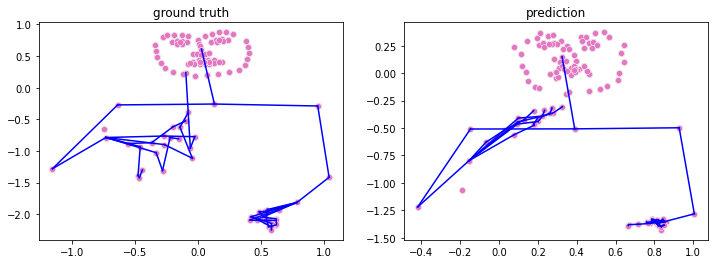

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
i=10
fig, ax = plt.subplots(1, 2 ,figsize=(12,4))
output = all_outputs["ground_truth"][i][0:11, 0:240]

x_output = output[2][0::2]
y_output = output[2][1::2]

for s in getSkeletalModelStructure():
    sns.lineplot(x=[x_output[s[0]], x_output[s[1]]],
                 y=[y_output[s[0]]*-1, y_output[s[1]]*-1], color='blue', ax=ax[0])
    
    sns.scatterplot(x=x_output, y=y_output*-1, ax=ax[0])
ax[0].set(title="ground truth")

# prediction
output = all_outputs["predictions"][i][0:11, 0:240]
x_output = output[2][0::2]
y_output = output[2][1::2]

for s in getSkeletalModelStructure():
    sns.lineplot(x=[x_output[s[0]], x_output[s[1]]],
                 y=[y_output[s[0]]*-1, y_output[s[1]]*-1], color='blue', ax=ax[1])
    
    sns.scatterplot(x=x_output, y=y_output*-1, ax=ax[1])
ax[1].set(title='prediction')

fig.show()